# Обнаружение объектов с помощью KerasCV

**Author:** [lukewood](https://twitter.com/luke_wood_ml), Ian Stenbit, Tirth Patel<br>
**Date created:** 2023/04/08<br>
**Last modified:** 2023/08/10<br>
**Description:** Train an object detection model with KerasCV.

KerasCV предлагает полный набор API-интерфейсов производственного уровня для решения задач обнаружения объектов.
проблемы.
Эти API включают в себя функции, специфичные для обнаружения объектов.
методы увеличения данных, собственные метрики COCO Keras, формат ограничительной рамки
утилиты преобразования, инструменты визуализации, предварительно обученные модели обнаружения объектов,
и все, что вам нужно для обучения собственному современному обнаружению объектов
модели!

Давайте попробуем API обнаружения объектов KerasCV.

In [1]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 19.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


In [5]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

## Введение в обнаружение объектов

Обнаружение объектов – это процесс идентификации, классификации,
и локализация объектов внутри данного изображения. Обычно ваши входные данные
изображения, а ваши метки представляют собой ограничивающие рамки с необязательным классом
этикетки.
Однако обнаружение объектов можно рассматривать как расширение классификации.
вместо одной метки класса для изображения необходимо обнаружить и локализовать
произвольное количество классов.

**Например:**

<img width="300" src="https://i.imgur.com/8xSEbQD.png">

Данные для изображения выше могут выглядеть примерно так:
```python
image = [height, width, 3]
bounding_boxes = {
  "classes": [0], # 0 — произвольный идентификатор класса, представляющий «кошку».
  "boxes": [[0.25, 0.4, .15, .1]]
   # ограничивающая рамка имеет формат «rel_xywh», поэтому 0,25 соответствует
   # началу ограничивающей рамки на 25 % пути по всему изображению.
   # .15 означает, что ширина составляет 15% ширины изображения.
}
```

С момента создания [*You Only Look Once*](https://arxiv.org/abs/1506.02640)
(он же ЙОЛО),
Обнаружение объектов в основном решалось с помощью глубокого обучения.
Большинство архитектур глубокого обучения делают это, умело определяя обнаружение объектов.
проблема как комбинация многих небольших задач классификации и
множество проблем с регрессией.

Точнее, это делается путем создания множества якорных блоков разной
формы и размеры входных изображений и присвоение каждому из них метки класса,
а также смещения `x`, `y`, `width` и `height`.
Модель обучена прогнозировать метки классов каждого ящика, а также
Смещения `x`, `y`, `width` и `height` для каждого блока, который, по прогнозам, будет
объект.

**Визуализация некоторых примеров ящиков привязки**:

<img width="400" src="https://i.imgur.com/cJIuiK9.jpg">

Обнаружение возражений — технически сложная задача, но, к счастью, мы предлагаем
надежный подход к получению отличных результатов.
Давай сделаем это!

## Выполняйте обнаружения с помощью предварительно обученной модели.

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_beginner.png)

API самого высокого уровня в API обнаружения объектов KerasCV — это API keras_cv.models.
Этот API включает в себя полностью предварительно обученные модели обнаружения объектов, такие как
`keras_cv.models.YOLOV8Detector`.

Давайте начнем с создания детектора YOLOV8, предварительно обученного на pascalvoc.
набор данных.

In [3]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

100%|██████████| 2.27k/2.27k [00:00<00:00, 2.17MB/s]
100%|██████████| 99.5M/99.5M [00:01<00:00, 87.4MB/s]


Обратите внимание на аргумент «bounding_box_format»?

Напомним, в разделе выше описан формат ограничивающих рамок:

```
bounding_boxes = {
  "classes": [num_boxes],
  "boxes": [num_boxes, 4]
}
```

Этот аргумент *точно* описывает формат значений в `"полях"`
поле словаря меток возьмите в свой конвейер.
Например, прямоугольник в формате xywh с левым верхним углом по координатам
(100, 100) шириной 55 и высотой 70 будут представлены следующим образом:
```
[100, 100, 55, 75]
```

или эквивалентно в формате xyxy:

```
[100, 100, 155, 175]
```

Хотя это может показаться простым, это важная часть объекта KerasCV.
API обнаружения!
Каждый компонент, обрабатывающий ограничивающие рамки, требует
Аргумент `bounding_box_format`.
Вы можете прочитать больше о
Форматы ограничивающей рамки KerasCV [в документации API](https://keras.io/api/keras_cv/bounding_box/formats/).


Это сделано потому, что не существует единственного правильного формата ограничивающих рамок!
Компоненты в разных конвейерах ожидают разных форматов, поэтому, требуя
их необходимо указать, мы гарантируем, что наши компоненты остаются читабельными, пригодными для повторного использования,
и ясно.
Ошибки преобразования формата блока, пожалуй, наиболее распространенные ошибки в объектах.
конвейеры обнаружения — требуя этот параметр, мы уменьшаем эти проблемы.
ошибки (особенно при объединении кода из многих источников).

Далее загрузим изображение:

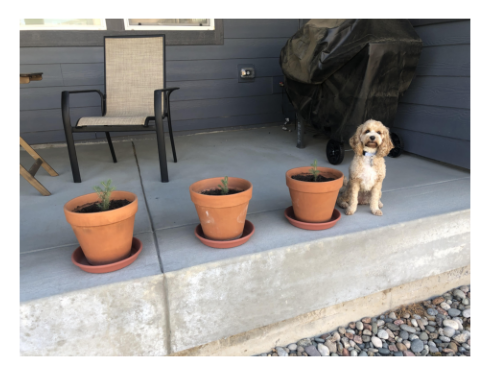

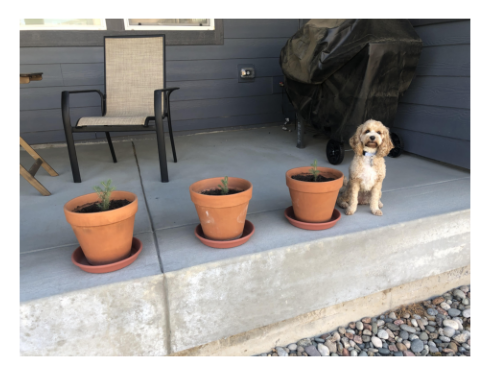

In [7]:
# filepath = keras.utils.get_file(origin="https://i.imgur.com/gCNcJJI.jpg") # Почему-то какртинка с сайта не грузится
image = keras.utils.load_img("горшки.png")
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

Чтобы использовать архитектуру YOLOV8Detector с магистральной сетью ResNet50, вам необходимо
измените размер изображения до размера, кратного 64. Это необходимо для обеспечения
совместимость с количеством операций уменьшения масштаба, выполняемых сверткой
слои в ResNet.

Если операция изменения размера искажает
соотношение сторон входного сигнала, модель будет работать значительно хуже. Для
предварительно обученный пресет `"yolo_v8_m_pascalvoc"`, который мы используем, последний
`MeanAveragePrecision` в оценочном наборе `pascalvoc/2012` падает до `0,15`
с `0,38` при использовании простой операции изменения размера.

Кроме того, если вы обрезаете изображение, чтобы сохранить соотношение сторон, как при классификации
в вашей модели могут полностью отсутствовать некоторые ограничивающие рамки. Таким образом, при выполнении вывода
в модели обнаружения объектов мы рекомендуем использовать отступы до желаемого размера,
при изменении размера самого длинного размера в соответствии с соотношением сторон.

KerasCV упрощает изменение размера; просто передайте `pad_to_aspect_ratio=True` в
слой `keras_cv.layers.Resizing`.

Это можно реализовать в одной строке кода:

In [8]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

Это можно использовать в качестве конвейера предварительной обработки вывода:

In [9]:
image_batch = inference_resizing([image])

`keras_cv.visualization.plot_bounding_box_gallery()` поддерживает `class_mapping`
параметр, чтобы указать, к какому классу было присвоено каждое поле. Давайте соберем
отображение классов сейчас.

In [11]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

Как и в случае с любой другой keras.Model, вы можете предсказать ограничивающие рамки, используя
`model.predict()` API.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


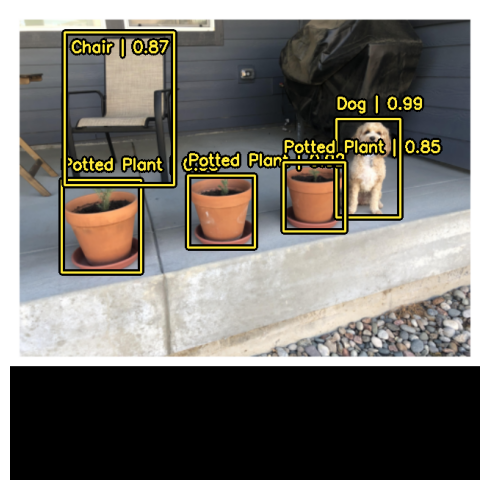

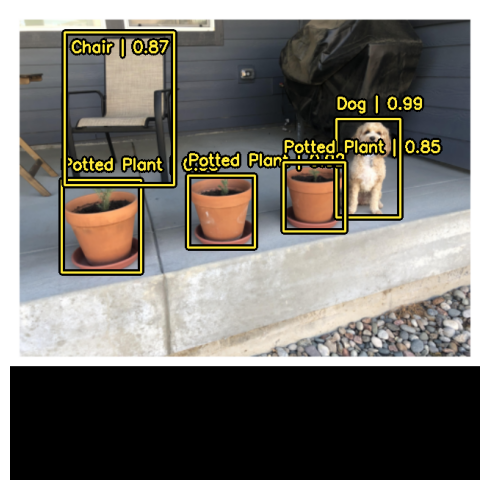

In [12]:
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

Чтобы поддержать этот простой и интуитивно понятный рабочий процесс вывода, KerasCV
выполняет немаксимальное подавление внутри класса YOLOV8Detector.
Немаксимальное подавление — это традиционный вычислительный алгоритм, решающий проблему.
модели, обнаруживающей несколько ящиков для одного и того же объекта.

Немаксимальное подавление — это легко настраиваемый алгоритм, и в большинстве случаев вы
захочу настроить параметры немаксимальной модели вашей модели
Операция по подавлению.
Это можно сделать путем переопределения аргумента `prediction_decoder`.

Чтобы продемонстрировать эту концепцию, давайте временно отключим немаксимальное подавление на нашем
YOLOV8Детектор. Это можно сделать, записав в атрибут prediction_decoder.

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


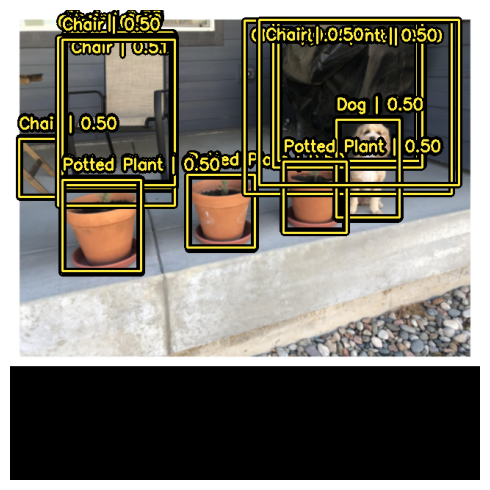

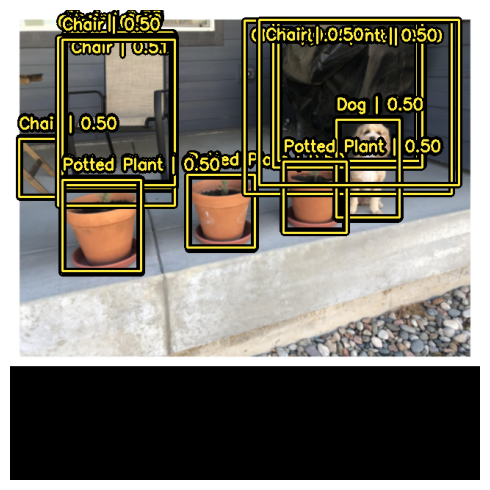

In [13]:
# The following NonMaxSuppression layer is equivalent to disabling the operation
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)


Далее давайте перенастроим keras_cv.layers.NonMaxSuppression для нашего
вариант использования!
В этом случае мы настроим iou_threshold на 0,2, а
`confidence_threshold` на `0,7`.

Повышение `confidence_threshold` приведет к тому, что модель будет выводить только поля.
которые имеют более высокий показатель достоверности. `iou_threshold` контролирует порог
пересечение через объединение (IoU), которое должно быть у двух ящиков, чтобы один был
обрезанный.
[Дополнительную информацию об этих параметрах можно найти в документации API TensorFlow] (https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


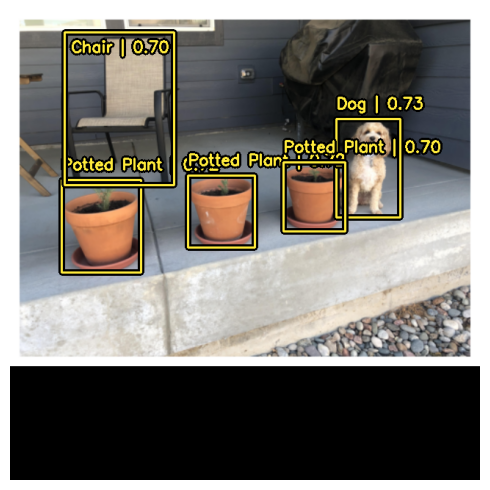

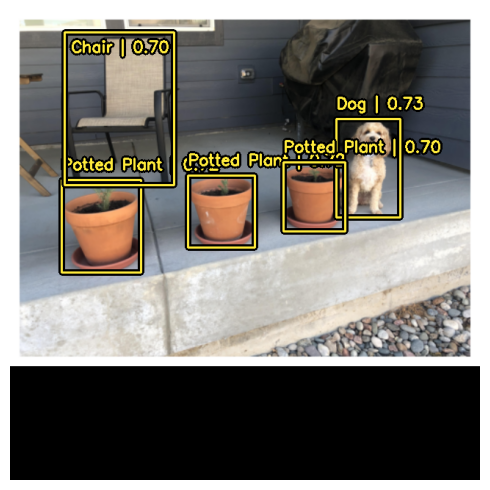

In [17]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.6,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

Это выглядит намного лучше!

## Обучение пользовательской модели обнаружения объектов

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_advanced.png)

Независимо от того, являетесь ли вы любителем обнаружения объектов или опытным ветераном, сборка конвейера обнаружения объектов с нуля — это масштабная задача. К счастью, все API обнаружения объектов KerasCV построены как модульные компоненты. Нужен ли вам полный конвейер, просто модель обнаружения объектов или даже просто утилита преобразования для преобразования ваших блоков из формата xywh в xyxy, KerasCV поможет вам.

В этом руководстве мы соберем полный конвейер обучения для модели обнаружения объектов KerasCV. Это включает в себя загрузку данных, увеличение, оценку показателей и логические выводы!

Для начала давайте разберемся со всем нашим импортом и определим глобальные параметры конфигурации.

In [ ]:
BATCH_SIZE = 4

## Загрузка данных

Для начала давайте обсудим загрузку данных и форматирование ограничивающей рамки. KerasCV имеет предопределенный формат ограничивающих рамок. Чтобы соответствовать этому, вам следует упаковать ограничивающие рамки в словарь, соответствующий приведенной ниже спецификации:

```
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}
```

bounding_boxes['boxes'] содержит координаты вашего ограничивающего прямоугольника в форматеbounding_box_format, поддерживаемом KerasCV. KerasCV требует аргументbounding_box_format во всех компонентах, которые обрабатывают ограничивающие рамки. Это сделано для того, чтобы максимизировать ваши возможности по подключению и использованию отдельных компонентов в их конвейерах обнаружения объектов, а также для обеспечения самодокументируемости кода во всех конвейерах обнаружения объектов.

Чтобы соответствовать стилю API KerasCV, при написании собственного загрузчика данных рекомендуется также поддерживать аргументbounding_box_format. Это дает понять тем, кто вызывает ваш загрузчик данных, в каком формате находятся ограничивающие рамки. В этом примере мы форматируем наши рамки в формат xywh.

Например:

```python
train_ds, ds_info = your_data_loader.load(
    split='train', bounding_box_format='xywh', batch_size=8
)
```

Это явно дает ограничивающие рамки в формате «xywh». Вы можете прочитать больше о
Форматы ограничивающей рамки KerasCV [в документации API] (https://keras.io/api/keras_cv/bounding_box/formats/).

Наши данные загружаются в формате
`{"images": изображения, "bounding_boxes":bounding_boxes}`. Этот формат
поддерживается во всех компонентах предварительной обработки KerasCV.

Давайте загрузим некоторые данные и проверим, что они выглядят так, как мы ожидаем.

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return ds


train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteP60A1X/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteP60A1X/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteP60A1X/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


Далее давайте группируем наши данные.

В задачах обнаружения объектов KerasCV рекомендуется
пользователи используют разрозненные пакеты входных данных.
Это связано с тем, что в PascalVOC изображения могут быть разного размера,
а также тот факт, что может быть разное количество ограничивающих рамок на
изображение.

Чтобы создать неоднородный набор данных в конвейере tf.data, вы можете использовать команду
метод `ragged_batch()`.

In [ ]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

Давайте убедимся, что наш набор данных соответствует формату, который ожидает KerasCV.
Используя функцию `visualize_dataset()`, вы можете визуально проверить
что ваши данные находятся в формате, ожидаемом KerasCV. Если ограничивающие рамки
не видны или видны не в тех местах, что является признаком того, что ваш
данные имеют неверный формат.

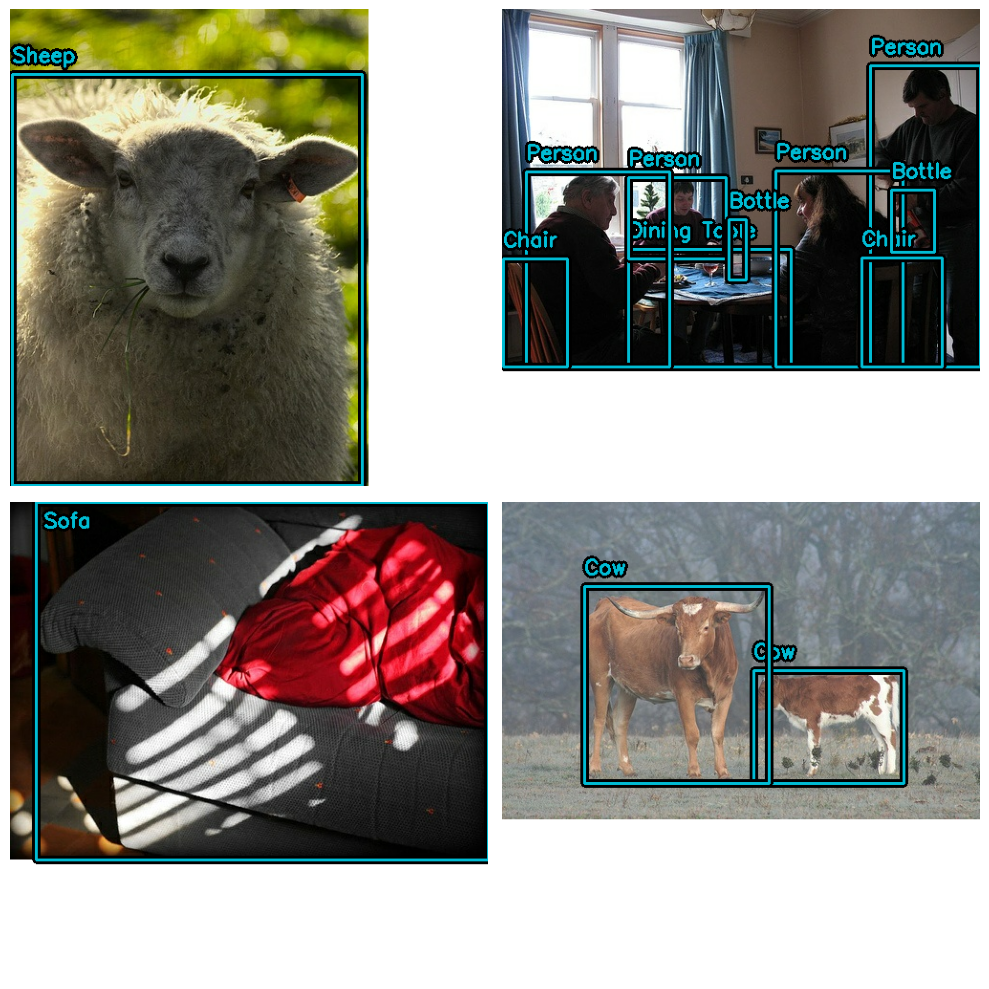

In [ ]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

И для оценочного набора:

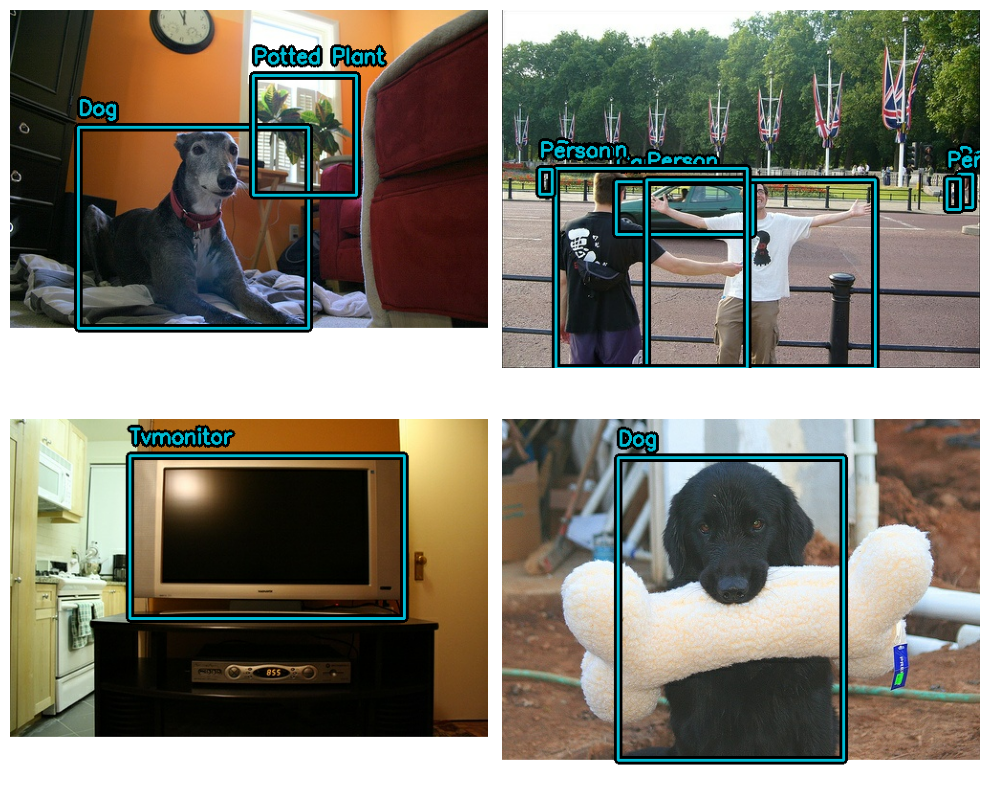

In [ ]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
    # Если вы не проводите эксперимент на локальном компьютере,
    # вы также можете заставить `visualize_dataset()` сбросить график в файл,
    # используя `path`: path="eval.png"
)

Похоже, все структурировано так, как и ожидалось.
Теперь мы можем перейти к построению нашего
конвейер увеличения данных.

## Увеличение данных

Одна из самых сложных задач при построении системы обнаружения объектов
конвейеры — это увеличение данных. Методы увеличения изображения должны учитывать лежащие в основе
ограничивающие рамки и должны обновить их соответствующим образом.

К счастью, KerasCV изначально поддерживает расширение ограничивающей рамки с помощью своих обширных возможностей.
библиотека
[слоев расширения данных] (https://keras.io/api/keras_cv/layers/preprocessing/).
Код ниже загружает набор данных Pascal VOC и выполняет операцию «на лету».
увеличение данных с учетом ограничивающей рамки внутри конвейера `tf.data`.

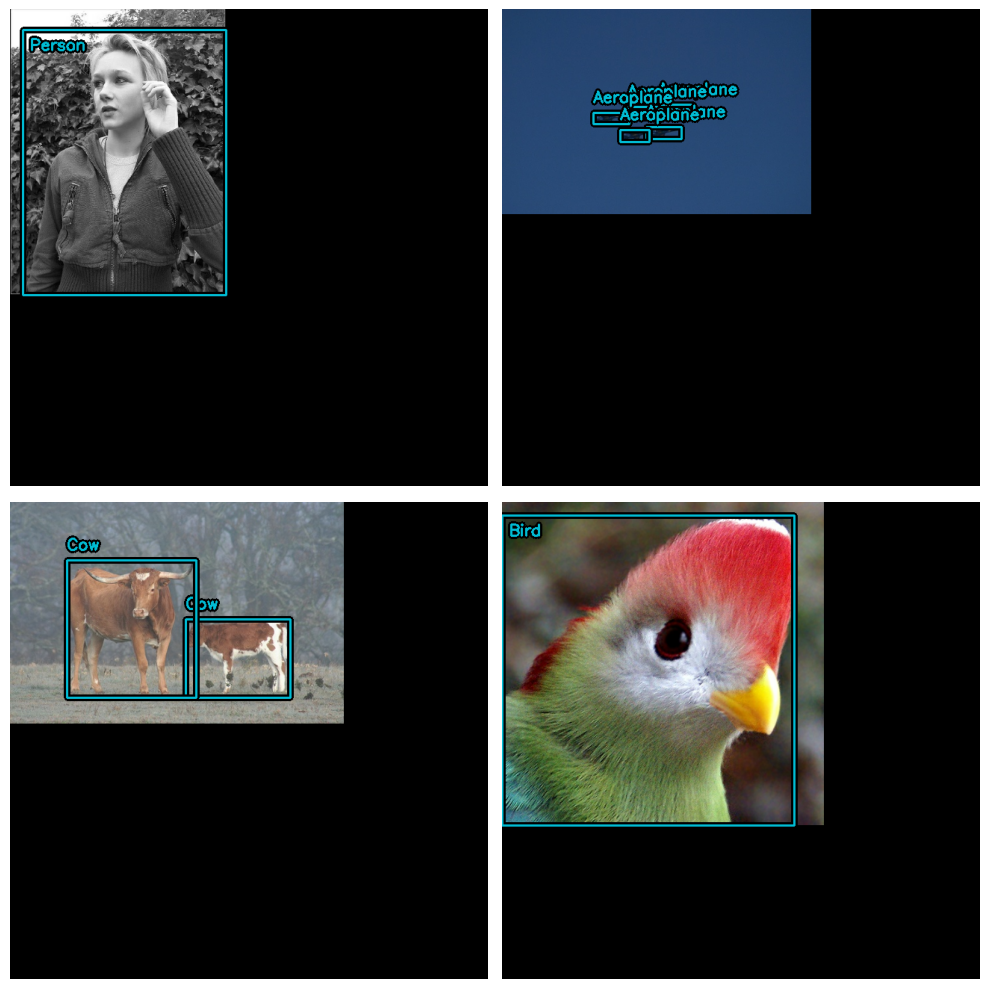

In [ ]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Большой! Теперь у нас есть конвейер пополнения данных, удобный для использования с ограничивающей рамкой.
Давайте отформатируем наш набор оценочных данных так, чтобы он соответствовал. Вместо использования
`JitteredResize`, давайте использовать детерминированный `keras_cv.layers.Resizing()`
слой.

In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

В связи с тем, что операция изменения размера различается в зависимости от набора данных поезда,
который использует JitteredResize() для изменения размера изображений, и набор данных вывода, который
использует `layers.Resizing(pad_to_aspect_ratio=True)`, рекомендуется
визуализируйте оба набора данных:

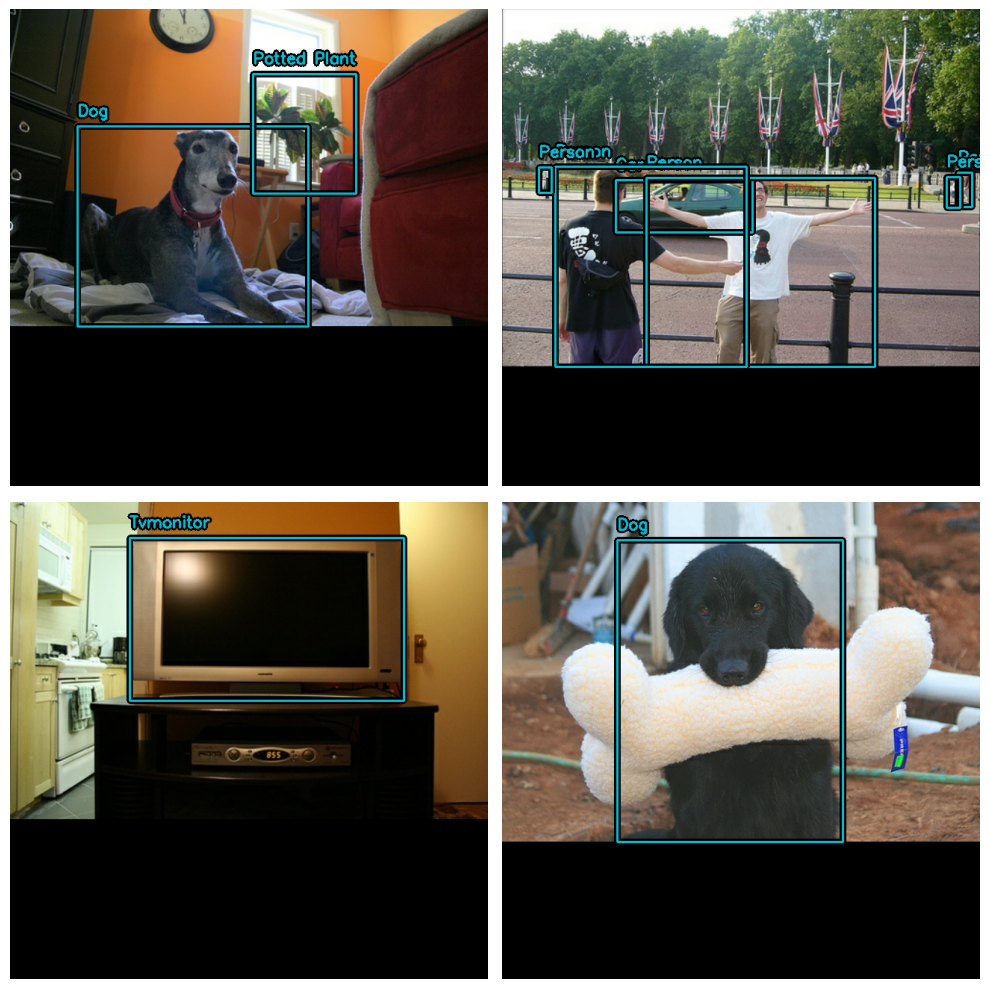

In [ ]:
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Наконец, давайте распакуем наши входные данные из словаря предварительной обработки и
подготовьтесь к подаче входных данных в нашу модель. Чтобы быть совместимым с ТПУ,
Ограничивающая рамка Тензоры должны быть «Плотными», а не «Рваными».

In [ ]:

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)

Был переведён через переводчик текст на русский.<br>
По какой-то причине не загрузилась с сайта картинка с горшками из раздела начинающего.<br>
В разделе "продвинутый" картинки в датасетах как тренировочном, так и в тестовом изменились (совсем другие картинки по сравнению с теми, что были изначально).<br>
В продвинутом разделе особо то и нечем "играться" ну не количеством же выводимых картинок в ряд и в столбец, с остальными параметрами "поигрались" на семинаре в разделе для "начинающих".<br>
Как готовый конструктор с хорошо подготовленным датасетом - достаточно простая и автоматизированная модель.<br>
Хотя не всё так уж и понятно: так и не понял, почему на "автомате" процент распознавания выше, чем когда начинаем настраивать. Чем регулируется цвет рамки - в начинающем он жёлтый, а в продвинутом - синий. Куда пропали проценты в "продвинутом" варианте?